#### Economics 8185 - PS1 ####
##### Advanced Topics in Macroeconomics-Computation #####
###### Belmudes Lucas, belmu002@umn.edu ######
###### 4th Of October, 2022 ######
<hr />

##### Exercise 1: #####

Compute the the following baby-step growht model:

$$
\max _{\left\{c_t, k_{t+1}\right\}} E \sum_{t=0}^{\infty} \beta^t \log \left(c_t\right)
$$
st, $$c_t+k_{t+1}=z_t k_t^\theta$$
$$
\log z_t=\rho \log z_{t-1}+\epsilon_t, \quad \epsilon \sim N\left(0, \sigma_\epsilon^2\right)
$$
Given, $$k_{0},z_{-1}$$

##### Method 1: Iterate on the Bellman's Equation #####

Step 0: Import modules.

In [23]:
import quantecon as qe
import numpy as np
import warnings
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from scipy import interpolate
warnings.filterwarnings("ignore", category=RuntimeWarning) 

Step 1: Create class.

In [24]:
class VFI:
    
    def __init__(self, ρ, n_k, n_z, lnz_bar, σ, θ, β, T=250):
        self.n_k = n_k                                                                  # No. of grid points for K.                                                       
        self.n_z = n_z                                                                  # No. of grid points for Z.
        self.ρ = ρ                                                                      # Memory of AR(1).
        self.σ = σ                                                                      # Variance of idd shocks.
        self.T = T                                                                      # Simulated periods.
        self.θ = θ                                                                      # Capital Share.
        self.β = β                                                                      # Discount Factor.
        self.h = np.ones([self.n_z, self.n_k])*-np.inf                                  # Policy Function.
        self.h_i = np.ones([self.n_z, self.n_k])*-np.inf                                # Index for policy function.
        self.markov = qe.markov.approximation.rouwenhorst(n_z, lnz_bar, self.σ, self.ρ) # Aux.
        self.Π = self.markov.P                                                          # Transition Matrix.
        self.z = np.exp(self.markov.state_values)                                       # TFP values in levels.
        self.K_max = self.z[-1]**(1/(1-self.θ))                                         # Max Sustainable Capital.
        self.K = np.linspace(0.01, self.K_max, self.n_k)                                # Capital Grid in levels.
        self.K_ss = (self.β*self.θ)**(1/(1-self.θ))
        self.V_0 = np.zeros([self.n_z, self.n_k])                                       # Aux.
        self.V_1 = np.ones([self.n_z, self.n_k])                                        # Aux.
        
    def U(self, x):
        return np.log(x)

    def error(self, V1, V2):
        return np.nanmax(np.abs(V1-V2)) 
        
    def update(self):                                                               # Opertator T:V_1->V_0.
        n_z = self.n_z
        n_k = self.n_k
        K = self.K
        Π = self.Π
        θ = self.θ
        β = self.β
        z = self.z
        self.V_0 = self.V_1.copy()
        for i in range(n_z):
            for j in range(n_k):
                self.V_1[i,j] = np.nanmax(self.U(z[i] * K[j]**(θ) - K) + β * np.matmul(Π[i,:], self.V_0))
        
    def converge(self, tolerance, max_iter):                                        # Iterate until convergence.
        self.iterations = 0
        while self.error(self.V_0, self.V_1) > tolerance and self.iterations < max_iter:
            self.update()
            self.iterations += 1        
        if self.iterations < max_iter:
            print("Solution Found.")
            self.solution()
        else:
            print("Error - No convergence.")
    
    def solution(self):                                                              # Compute policy functions.
        V = self.V_1
        n_z = self.n_z
        n_k = self.n_k
        Π = self.Π
        z = self.z
        K = self.K
        θ = self.θ
        β = self.β
        self.K = np.linspace(0.001, self.K_max, self.n_k)
        for r in range(n_z):
            for c in range(n_k):
                self.h_i[r,c] = np.nanargmax(self.U( z[r] * K[c]**(θ) - K) + β * ( Π[r,:] @ V))
                self.h[r,c] = K[int(self.h_i[r,c])]   
        
                
    def plot(self):                                                                # Plots.
        fig, ax = plt.subplots(3, figsize=(20, 20))
        #Value function:
        ax[0].plot(self.K[(self.K > 0.1)], self.V_1[round(self.n_z*0.25),(self.K > 0.1)], 'r-', linewidth=2, label=r'$z_{25pctl}$', alpha=0.6)
        ax[0].plot(self.K[(self.K > 0.1)], self.V_1[round(self.n_z*0.50),(self.K > 0.1)], 'b-', linewidth=2, label=r'$z_{50pctl}$', alpha=0.6)
        ax[0].plot(self.K[(self.K > 0.1)], self.V_1[round(self.n_z*0.75),(self.K > 0.1)], 'g-', linewidth=2, label=r'$z_{75pctl}$', alpha=0.6)
        ax[0].set_title("Value function given Z")
        ax[0].set_xlabel("K")
        ax[0].set_ylabel("V(z,k)")
        ax[0].legend(loc="upper right")
        #Policy:
        ax[1].plot(self.K[(self.K > 0.1)], self.h[round(self.n_z*0.25),(self.K > 0.1)], 'r-', linewidth=2, label=r'$z_{25pctl}$', alpha=0.6)
        ax[1].plot(self.K[(self.K > 0.1)], self.h[round(self.n_z*0.50),(self.K > 0.1)], 'b-', linewidth=2, label=r'$z_{50pctl}$', alpha=0.6)
        ax[1].plot(self.K[(self.K > 0.1)], self.h[round(self.n_z*0.75),(self.K > 0.1)], 'g-', linewidth=2, label=r'$z_{50pctl}$', alpha=0.6)
        ax[1].set_title("Capital tomorrow given Z")
        ax[1].set_ylabel(r'$K^{\prime}$')
        ax[1].set_xlabel("K")
        ax[1].legend(loc="upper right")
        # Simulation:
        hf = interpolate.interp2d(self.K, self.z, self.h, kind='cubic')
        for i in range(4):
            e = np.random.normal(0, self.σ, self.T)
            lnz_shocks = np.empty(self.T)
            k_series = np.empty(self.T)
            lnz_shocks[0] = 0
            k_series[0] = self.K_ss
            for i in range(self.T):
                if i>0:
                    lnz_shocks[i] = self.ρ * lnz_shocks[i-1] + e[i-1]
                    k_series[i] = hf(k_series[i-1],np.exp(lnz_shocks[i-1]))
            ax[2].plot(np.linspace(1,self.T,self.T), k_series)  
        ax[2].set_xlabel("t")
        ax[2].set_ylabel(r'$K_t$')  
        ax[2].set_title("Multiple Simulations, Same " r'$K_0$')
        plt.show()

Step 3: Iterate till convergence.

In [25]:
# Create the instance of the class given the paramaters:

Baby_Economy_Method_1 = VFI(ρ = 0.9, n_k = 1000, n_z = 25, lnz_bar = 0, σ = 0.01, θ = 0.7, β = 0.95)                           
Baby_Economy_Method_1.converge(10e-5, 10000)

Solution Found.


Step 4: Plots:


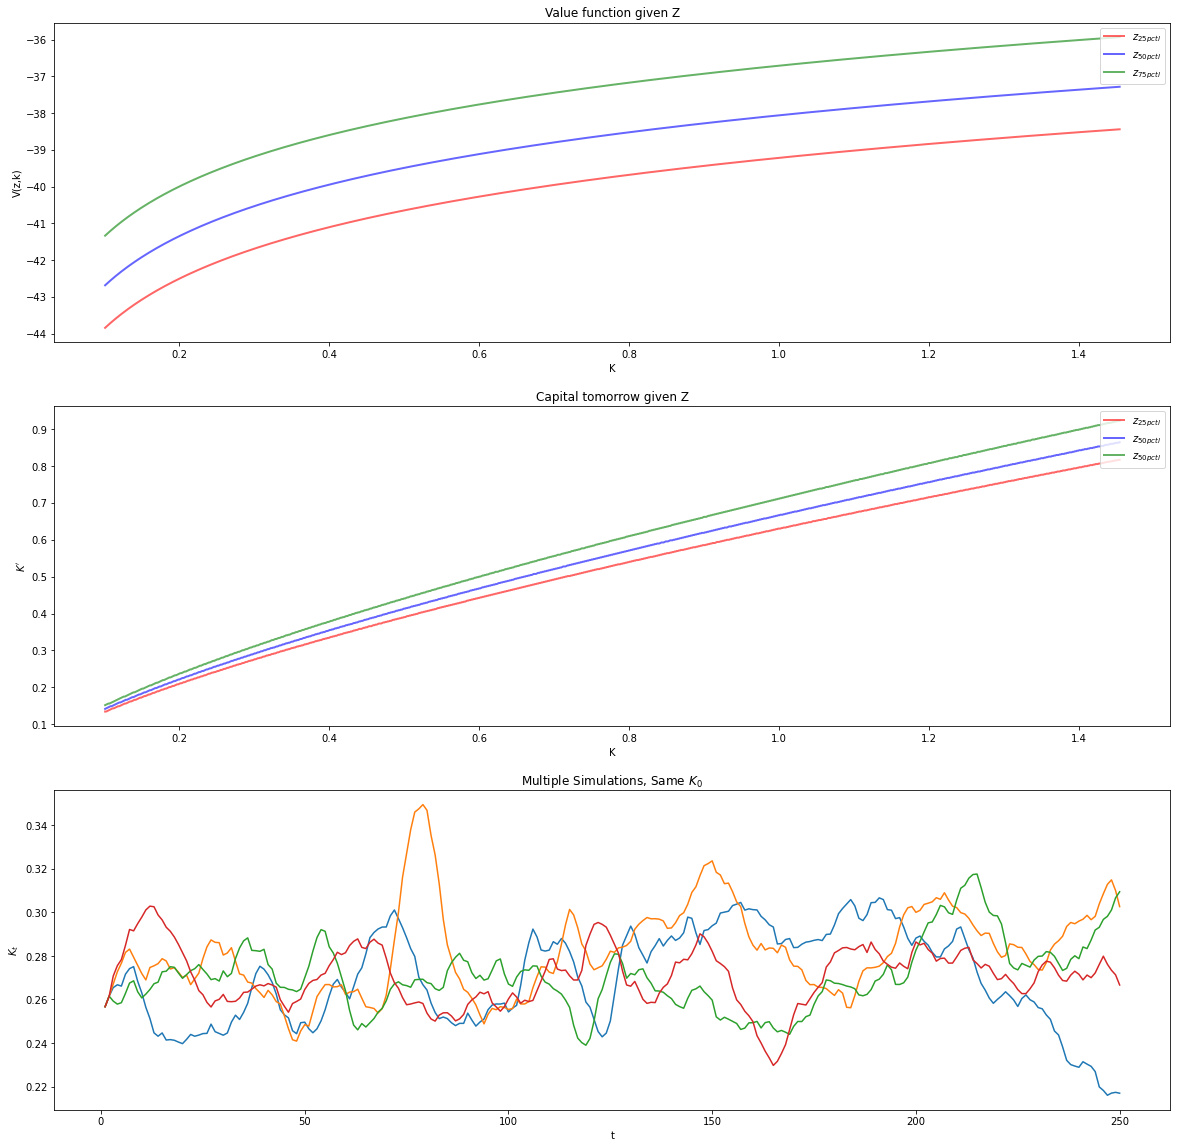

In [26]:
Baby_Economy_Method_1.plot()

Step 5: Analysis.

* We see that the value function for a given Z is concave in K.
* Capital tomorrow is a strictly increasing function of capital today and the TFP level. 
* The value function is increasing in TFP.

Future upgrades:

* The way graphs are constructed is not tidy. 
* Read more about interpolate.interp2d. 
* Read more about rouwenhorst
* The code is Slow. Try to make it compatible with JitClass. 


<hr />

### Method 2: Map it to a QL problem ###


Step 0: Import modules.

In [27]:
import numpy as np
import matplotlib.pyplot as plt

Step 1: Create derivatives class.

In [28]:
#Define the Jacobian and Hessian Class:

class derivatives:
    
    def __init__(self, g, z, s, d, Δ=10e-8):
        self.g = g
        self.z = z
        self.s = s
        self.d = d
        self.Δ = Δ
        self.J = np.zeros([3,1])
        self.H = np.zeros([3,3])
    
    def Δz(self, z, s, d):
        g = self.g
        Δ = self.Δ
        return (g(z + np.maximum(self.Δ, 10e-4*np.abs(z)), s, d) - g(z , s, d)) / np.maximum(self.Δ, 10e-4*np.abs(z))
    
    def Δs(self, z, s, d):
        g = self.g
        Δ = self.Δ
        return (g(z, s + np.maximum(self.Δ, 10e-4*np.abs(s)), d) - g(z , s, d)) / np.maximum(self.Δ, 10e-4*np.abs(s))
    
    def Δd(self, z, s, d):
        g = self.g
        Δ = self.Δ
        return (g( z, s, d + np.maximum(self.Δ, 10e-4*np.abs(d)) ) - g( z, s, d)) / np.maximum(self.Δ, 10e-4*np.abs(d))
    
    def Δzz(self, z, s, d):
        Δ = self.Δ
        return (self.Δz( z + np.maximum(self.Δ, 10e-4*np.abs(z)), s, d) - self.Δz( z, s, d)) / np.maximum(self.Δ, 10e-4*np.abs(z)) 
    
    def Δzs(self, z, s, d):
        Δ = self.Δ
        return (self.Δz(z, s + np.maximum(self.Δ, 10e-4*np.abs(s)), d) - self.Δz(z , s, d)) / np.maximum(self.Δ, 10e-4*np.abs(s)) 
    
    def Δzd(self, z, s, d):
        Δ = self.Δ
        return (self.Δz(z , s, d + np.maximum(self.Δ, 10e-4*np.abs(d))) - self.Δz(z , s, d)) / np.maximum(self.Δ, 10e-4*np.abs(d)) 
    
    def Δss(self, z, s, d):
        Δ = self.Δ
        return (self.Δs(z, s + np.maximum(self.Δ, 10e-4*np.abs(s)), d) - self.Δs(z , s, d)) / np.maximum(self.Δ, 10e-4*np.abs(s)) 
    
    def Δsd(self, z, s, d):
        Δ = self.Δ
        return (self.Δs(z, s, d + np.maximum(self.Δ, 10e-4*np.abs(d))) - self.Δs(z , s, d)) / np.maximum(self.Δ, 10e-4*np.abs(d)) 
    
    def Δdd(self, z, s, d):
        Δ = self.Δ
        return (self.Δd(z, s, d + np.maximum(self.Δ, 10e-4*np.abs(d)))  - self.Δd(z , s, d)) / np.maximum(self.Δ, 10e-4*np.abs(d))    
    
    def compute(self):
        z = self.z
        s = self.s
        d = self.d
        g = self.g
        self.J[0,0] = self.Δz( z, s, d)
        self.J[1,0] = self.Δs( z, s, d)
        self.J[2,0] = self.Δd( z, s, d)
        self.H[0,0] = self.Δzz( z, s, d)
        self.H[1,1] = self.Δss( z, s, d)
        self.H[2,2] = self.Δdd( z, s, d)
        self.H[0,1] = self.Δzs( z, s, d)
        self.H[1,0] = self.Δzs( z, s, d)
        self.H[0,2] = self.Δzd( z, s, d)
        self.H[2,0] = self.Δzd( z, s, d)
        self.H[2,1] = self.Δsd( z, s, d)
        self.H[1,2] = self.Δsd( z, s, d)  

Step 4: Define return function.

In [29]:
#The return function:

def function(z, s, d, θ = 0.7):
    return np.log( np.exp(z) * np.exp(θ*s) - np.exp(d))

Step 4: Compute LQ algorithm.

In [32]:
# Compute the QL
class LQ:
    
    def __init__(self, g, J, H, z_ss, k0_ss, k1_ss, ρ=0.9, β = 0.95, nz=25, nk=100, T=250, σ=0.01, θ=0.7):
    
        #Unload parameters
        self.θ = θ
        self.σ = σ
        self.T = T
        self.β = β
        self.g = g
        self.J = J
        self.H = H
        self.ρ = ρ
        self.k0_ss = k0_ss
        self.k1_ss = k1_ss
        self.z_ss = z_ss
        self.nk = nk
        self.nz = nz
        self.V = np.zeros([nz,nk])
        
        #Define matrices
        
        self.R = g(z_ss, k0_ss, k1_ss)
        self.W = np.array([[z_ss, k0_ss, k1_ss]]).T
        self.Q11 = self.R - self.W.T @ J + 0.5 * (self.W.T @ H @ self.W)
        self.Q12 = 0.5 * (J  - H @ self.W)
        self.Q22 = 0.5 * H  
        self.Q = np.concatenate((np.concatenate((self.Q11, self.Q12), axis=0),\
                                 np.concatenate((self.Q12.T, self.Q22), axis=0)), axis=1)
        self.B = np.array([[1, 0, 0, 0],[0, ρ, 0, 0],[0, 0, 0, 1]])
        self.P_1 = np.zeros([3,3])
        self.J_n = np.zeros([1,3])
    
    def solver(self):
        β = self.β
        i = 0
        P_0 = np.zeros([3,3])
        Q_ff = self.Q[0:3, 0:3]
        Q_fd = np.array([self.Q[3, 0:3]])
        Q_dd = np.array([self.Q[3, 3]])
        Q_df = Q_fd.T
                            
        while i<20000:
            
            M = self.B.T @ P_0 @ self.B        
            M_ff = M[0:3, 0:3]
            M_fd = M[3, 0:3]
            M_dd = M[3,3]
            M_df = M_fd.T
            
            P_1 = Q_ff + β * M_ff - ((Q_fd + β * M_fd).T  @ (Q_fd + β * M_fd)) * (Q_dd + β * M_dd)**(-1)
            i += 1
                        
            if np.max(np.abs(P_1 - P_0))< 10e-5:
                self.J_n = (-(Q_dd + β * M_dd)**(-1) * (Q_fd + β * M_fd))
                self.P_1 = P_1
                print("Solution Found")
                
                break
                
            else:
                P_0 = P_1.copy()
                
        if i>20000:
               self.J_n = self.J_n * -inf  
        
    def full_analysis(self):
        self.solver()
        for r in range(self.nz):
            for c in range(self.nk):
                K = np.linspace(0.1, 1.5, self.nk)
                Z = np.linspace(0.95, 1.05, self.nz)
                F = (np.array([[1, np.log(Z[r]), np.log(K[c])]])).T
                self.V[r,c] = F.T @ self.P_1 @ F       
        x = K
        y = self.V[round((self.nz)/2),:]
        fig, ax = plt.subplots(2, figsize=(20,20))
        ax[0].plot(x, y, 'b-', linewidth=2, label=r'$z_{50pctl}$')
        ax[0].set_title("Value function given Z")
        ax[0].set_xlabel("K")
        ax[0].set_ylabel("V(z,k)")
        ax[0].legend(loc="upper right")
        for i in range(4):
            e = np.random.normal(0, self.σ, self.T)
            lnz_shocks = np.empty(self.T)
            lnk_series = np.empty(self.T)
            lnz_shocks[0] = 0
            lnk_series[0] = np.log((self.θ*self.β)**(1/(1-self.θ)))
            for i in range(self.T):
                if i>0:
                    lnz_shocks[i] = self.ρ * lnz_shocks[i-1] + e[i-1]
                    lnk_series[i] = self.J_n @ [1, lnz_shocks[i-1], lnk_series[i-1]]
            ax[1].plot(np.linspace(1,self.T,self.T), np.exp(lnk_series))   
        ax[1].set_xlabel("t")
        ax[1].set_ylabel(r'$K_t$')  
        ax[1].set_title("Simulation")
        plt.show()
    

Step 5: Plots.

Solution Found


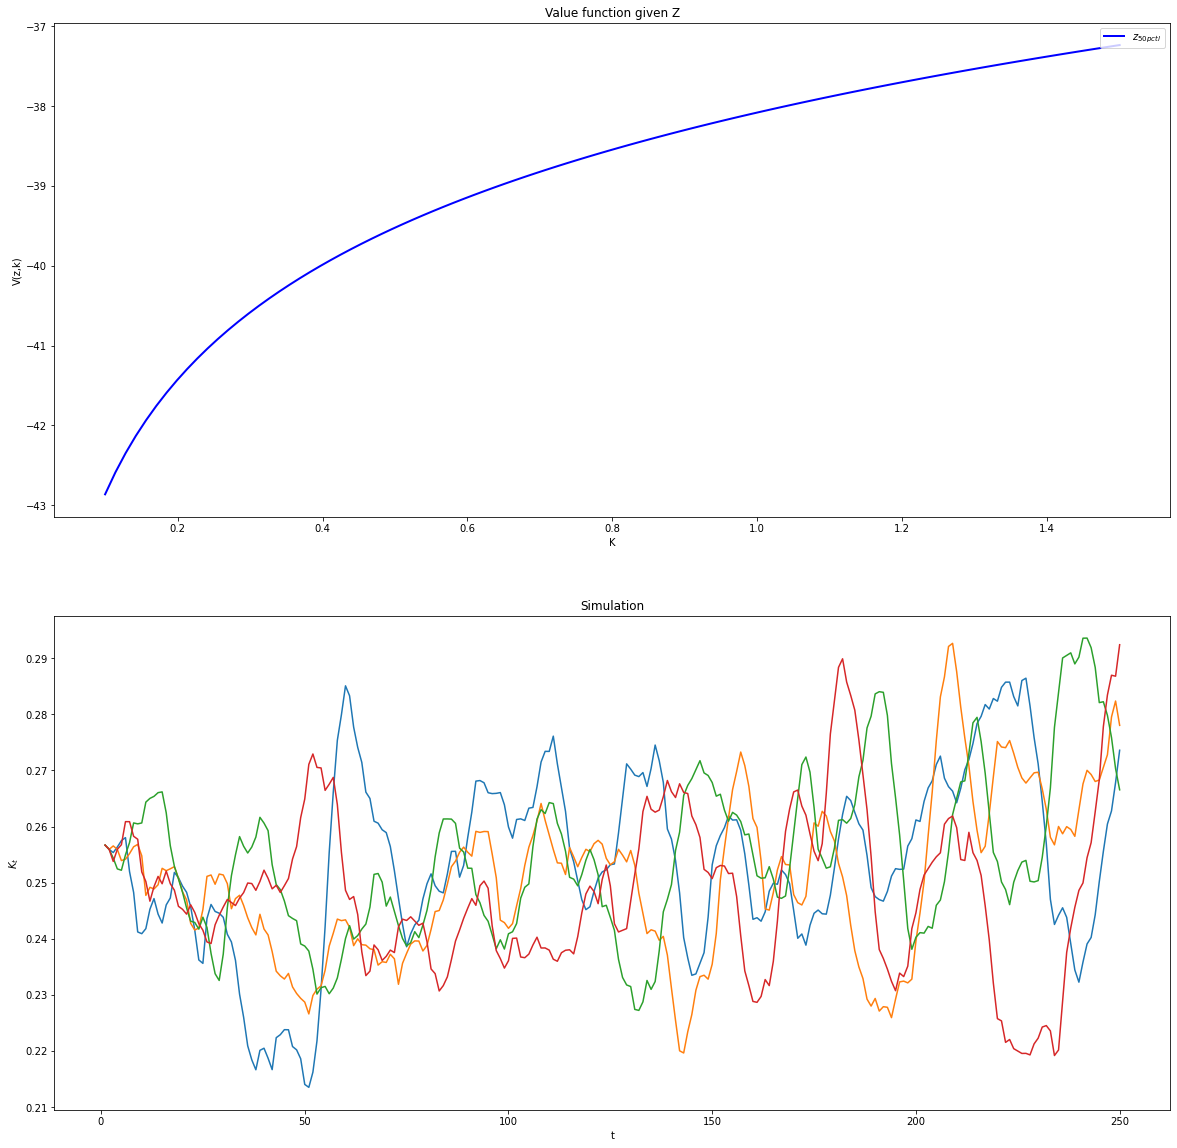

In [33]:
θ = 0.7
β = 0.95
f = derivatives(function, 0, np.log((θ*β)**(1/(1-θ))), np.log((θ*β)**(1/(1-θ))))
f.compute()
Solution = LQ(function, f.J, f.H, 0, np.log((θ*β)**(1/(1-θ))), np.log((θ*β)**(1/(1-θ))))
Solution.full_analysis()

Step 6: Analysis.

* All the previous results hold.

<hr />

#### Method 3: Apply Vaughan’s method. ####

Step 0: Import modules.

In [34]:
import numpy as np
import sympy
from numpy import *
from sympy import *
import matplotlib.pyplot as plt

Step 1: Obtain the second order taylor approximation 

Step 1.1: Define class derivatives

In [35]:
#Define the First, Second and Cross derivatives:

class derivatives:
    
    def __init__(self, g, z, s, d, Δ=10e-6):
        self.g = g
        self.z = z
        self.s = s
        self.d = d
        self.Δ = Δ
        self.J = np.zeros([3,1])
        self.H = np.zeros([3,3])
    
    def Δz(self, z, s, d):
        g = self.g
        Δ = self.Δ
        return ( g(z + np.maximum(self.Δ, 10e-4*np.abs(z)), s, d) - g(z , s, d)) / np.maximum(self.Δ, 10e-4*np.abs(z))
    
    def Δs(self, z, s, d):
        g = self.g
        Δ = self.Δ
        return (g(z, s + np.maximum(self.Δ, 10e-4*np.abs(s)), d) - g(z , s, d)) / np.maximum(self.Δ, 10e-4*np.abs(s))
    
    def Δd(self, z, s, d):
        g = self.g
        Δ = self.Δ
        return (g( z, s, d + np.maximum(self.Δ, 10e-4*np.abs(d)) ) - g( z, s, d)) / np.maximum(self.Δ, 10e-4*np.abs(d))
    
    def Δzz(self, z, s, d):
        Δ = self.Δ
        return (self.Δz( z + np.maximum(self.Δ, 10e-4*np.abs(z)), s, d) - self.Δz( z, s, d)) / np.maximum(self.Δ, 10e-4*np.abs(z)) 
    
    def Δzs(self, z, s, d):
        Δ = self.Δ
        return (self.Δz(z, s + np.maximum(self.Δ, 10e-4*np.abs(s)), d) - self.Δz(z , s, d)) / np.maximum(self.Δ, 10e-4*np.abs(s)) 
    
    def Δzd(self, z, s, d):
        Δ = self.Δ
        return (self.Δz(z , s, d + np.maximum(self.Δ, 10e-4*np.abs(d))) - self.Δz(z , s, d)) / np.maximum(self.Δ, 10e-4*np.abs(d)) 
    
    def Δss(self, z, s, d):
        Δ = self.Δ
        return (self.Δs(z, s + np.maximum(self.Δ, 10e-4*np.abs(s)), d) - self.Δs(z , s, d)) / np.maximum(self.Δ, 10e-4*np.abs(s)) 
    
    def Δsd(self, z, s, d):
        Δ = self.Δ
        return (self.Δs(z, s, d + np.maximum(self.Δ, 10e-4*np.abs(d))) - self.Δs(z , s, d)) / np.maximum(self.Δ, 10e-4*np.abs(d)) 
    
    def Δdd(self, z, s, d):
        Δ = self.Δ
        return (self.Δd(z, s, d + np.maximum(self.Δ, 10e-4*np.abs(d)))  - self.Δd(z , s, d)) / np.maximum(self.Δ, 10e-4*np.abs(d)) 

 Step 1.2: Define return function & create instance of class derivatives 

In [36]:
ρ_ss = 0.9
β_ss = 0.95
θ_ss = 0.7 
z_ss = 0
s_ss = np.log((θ_ss*β_ss)**(1/(1-θ_ss)))
d_ss = np.log((θ_ss*β_ss)**(1/(1-θ_ss)))

def function(z, s, d, θ = θ_ss ):
    return np.log( np.exp(z) * np.exp(θ*s) - np.exp(d))

f = derivatives(function, z = z_ss, s = s_ss, d = d_ss)

Step 1.3: Construct Taylor approximation.

In [37]:
# We will create a dictionary to store the coefficients of the Taylor approximation:

z, s, d = symbols('z s d')

Taylor = function(z_ss, s_ss, d_ss) + \
            f.Δz(z_ss, s_ss, d_ss) * (z - z_ss) + f.Δs(z_ss, s_ss, d_ss) * (s - s_ss) +  f.Δd(z_ss, s_ss, d_ss) * (d - d_ss) + \
                0.5 * (f.Δzz(z_ss, s_ss, d_ss) * (z - z_ss)**2 + f.Δss(z_ss, s_ss, d_ss) * (s - s_ss)**2 +  f.Δdd(z_ss, s_ss, d_ss) * (d - d_ss)**2) + \
                    f.Δzs(z_ss, s_ss, d_ss) * (z - z_ss) * (s - s_ss) + f.Δzd(z_ss, s_ss, d_ss) * (z - z_ss) * (d - d_ss) + f.Δsd(z_ss, s_ss, d_ss) * (s - s_ss) * (d - d_ss)
coeff = sympy.expand(Taylor).as_coefficients_dict()
for k in coeff.keys():
    coeff[k] = float(coeff[k])

Step 2: Unpack coefficients into matrices.

In [38]:
R = np.array([coeff[d**2]])
W = np.array([[ 0.5 * coeff[d]],  [0.5 * coeff[d*s]] , [ 0.5 *coeff[d * z]]])
Q = np.array([[coeff[1], 0.5 * coeff[s], 0.5 * coeff[z]], [ 0.5 * coeff[s], coeff[s**2], 0.5 * coeff[s*z]], [ 0.5 * coeff[z], 0.5 * coeff[s*z], coeff[z**2]]])
A = np.array([[1, 0, 0], [0, 0, 0], [0, 0, ρ_ss]])
B = np.array([[0],[1],[0]])

Step 3: Apply the method.

In [39]:
A_bar = np.sqrt(β_ss) * (A - (B * (1/R) @ W.T))
B_bar = np.sqrt(β_ss) * B
Q_bar = Q - (W @ W.T) * (1/R) 
H11 = np.linalg.inv(A_bar)
H12 = np.linalg.inv(A_bar) @ B_bar * (1/R) @ B_bar.T
H21 = Q_bar @ np.linalg.inv(A_bar)
H22 = Q_bar @ np.linalg.inv(A_bar) @ B_bar * (1/R) @ B_bar.T + A_bar.T
H = np.concatenate((np.concatenate((H11,H12),1),np.concatenate((H21,H22),1)),0)
λ, v = np.linalg.eig(H)
index = np.where(np.sqrt(λ.real**2 + λ.imag**2)>1, 1, 0)
Λ = np.diag(λ[(index)==True])

In [40]:
V = np.empty([shape(H)[0],shape(H)[0]])
aux_1 = 0
aux_2 = 0 
for i in range(shape(H)[0]):
    if index[i] == 1:
        V[:, aux_1] = v[:, i]
        aux_1 += 1 
    if index[i] == 0:
        V[:, -1-aux_2] = v[:, i]
        aux_2 += 1

V_11 = V[0:3, 0:3]
V_21 = V[3:6, 0:3]
V_12 = V[0:3, 3:6]
V_22 = V[3:6, 3:6]

P = V_21 @ np.linalg.inv(V_11)
F = (R + B_bar.T @ P @ B_bar)**-1 * (B_bar.T @ P @ A_bar) + R**-1 * W.T 

Step 4: Plots.

In [41]:
def V(lnk, lnz):
    if lnk.shape[0] == lnz.shape[0]:
            X = np.concatenate((np.concatenate((np.ones((lnk.shape[0],1)), lnk), 1), lnz), 1)
            return np.diag(X @ P @ X.T)

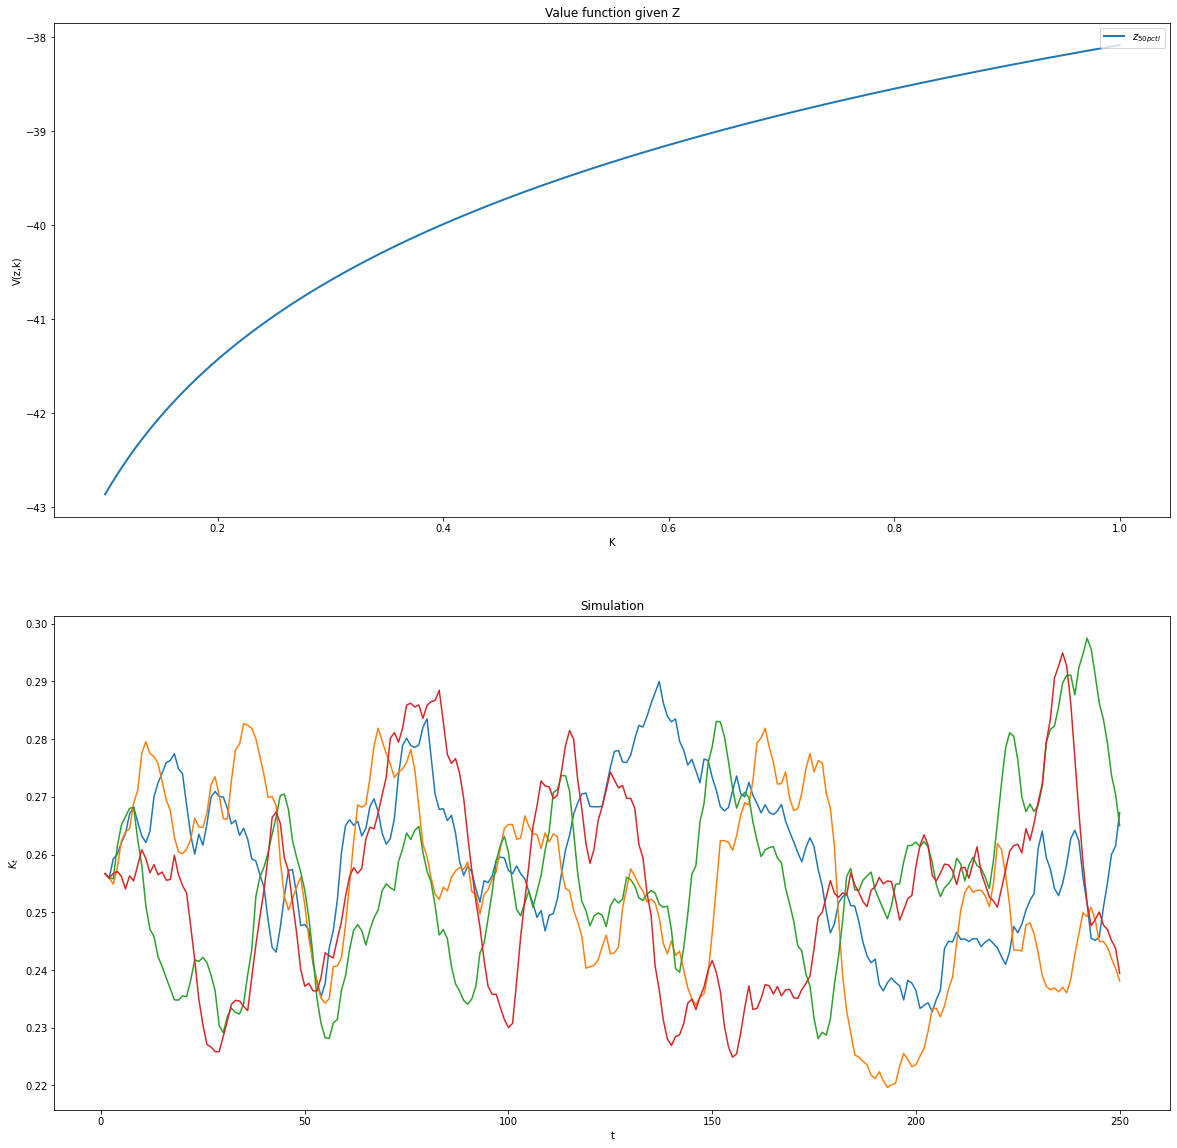

In [43]:
T = 250
σ = 0.01
n_k = 1000
ρ = 0.9
fig, ax = plt.subplots(2, figsize=(20,20))
ax[0].plot(np.linspace(0.1,1,n_k), V(np.log(np.linspace(0.1,1,n_k).reshape(n_k,1)),np.linspace(0,0,n_k).reshape(n_k,1)), linewidth=2, label=r'$z_{50pctl}$')
ax[0].set_title("Value function given Z")
ax[0].set_xlabel("K")
ax[0].set_ylabel("V(z,k)")
ax[0].legend(loc="upper right")
for i in range(4):
    e = np.random.normal(0, σ, T)
    lnz_shocks = np.empty(T)
    lnk_series = np.empty(T)
    lnz_shocks[0] = 0
    lnk_series[0] = np.log((θ*β)**(1/(1-θ)))
    for i in range(T):
        if i>0:
            lnz_shocks[i] = ρ * lnz_shocks[i-1] + e[i-1]
            lnk_series[i] = -1 * F @ [1, lnk_series[i-1], lnz_shocks[i-1]]
    ax[1].plot(np.linspace(1,T,T), np.exp(lnk_series))   
ax[1].set_xlabel("t")
ax[1].set_ylabel(r'$K_t$')  
ax[1].set_title("Simulation")
plt.show()

Step 5: Analysis.

* All the previous result still hold. 
* There is no iteration involved in this procedure. We can find the solution really fast.
* We dont need to define an error tolerance, grid density or anything else.